In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_1samp, norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from scipy.stats import ks_2samp, kstest, norm, skew, boxcox
import numpy as np
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from scipy.stats import mstats

In [12]:
# Set global font sizes for Matplotlib
plt.rcParams.update({
    'axes.titlesize': 20,      # Title font size
    'axes.labelsize': 18,      # Axis labels font size
    'xtick.labelsize': 16,     # X-axis tick labels font size
    'ytick.labelsize': 16,     # Y-axis tick labels font size
    'legend.fontsize': 16,     # Legend font size
})

In [13]:
df = pd.read_csv("dataset.csv", delimiter=";")

In [14]:
df.head()

,meanR,meanG,meanB,stdR,stdG,stdB,skewR,skewG,skewB,kurR,kurG,kurB,entR,entG,entB,Class
0,17.395776,18.057278,4.548844,40.818315,42.747400,15.235375,2.080558,2.117612,4.194824,2.786645,2.922868,18.932746,11.312396,11.302187,10.864530,1
1,17.048930,17.143965,4.285857,41.389466,42.116279,14.243516,2.185737,2.233318,4.195780,3.243245,3.436646,19.700106,11.256998,11.242310,10.867538,1
2,19.957301,16.498584,5.082156,48.724795,40.816921,15.203335,2.169338,2.245723,3.863509,3.069086,3.474671,17.313374,11.242156,11.228013,11.041794,1
3,19.713066,18.029258,4.707696,47.484912,43.629222,14.230307,2.135099,2.147982,3.987222,2.920590,2.926331,18.956953,11.266421,11.260806,11.034323,1
4,17.383914,14.581238,4.632718,46.006665,38.900382,14.446719,2.417031,2.458251,3.903999,4.259136,4.460186,17.438845,11.103429,11.094264,10.944285,1


In [15]:
X = df.drop(columns=["Class"])
y = df["Class"]

# Step 2: Split into 80-20 training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

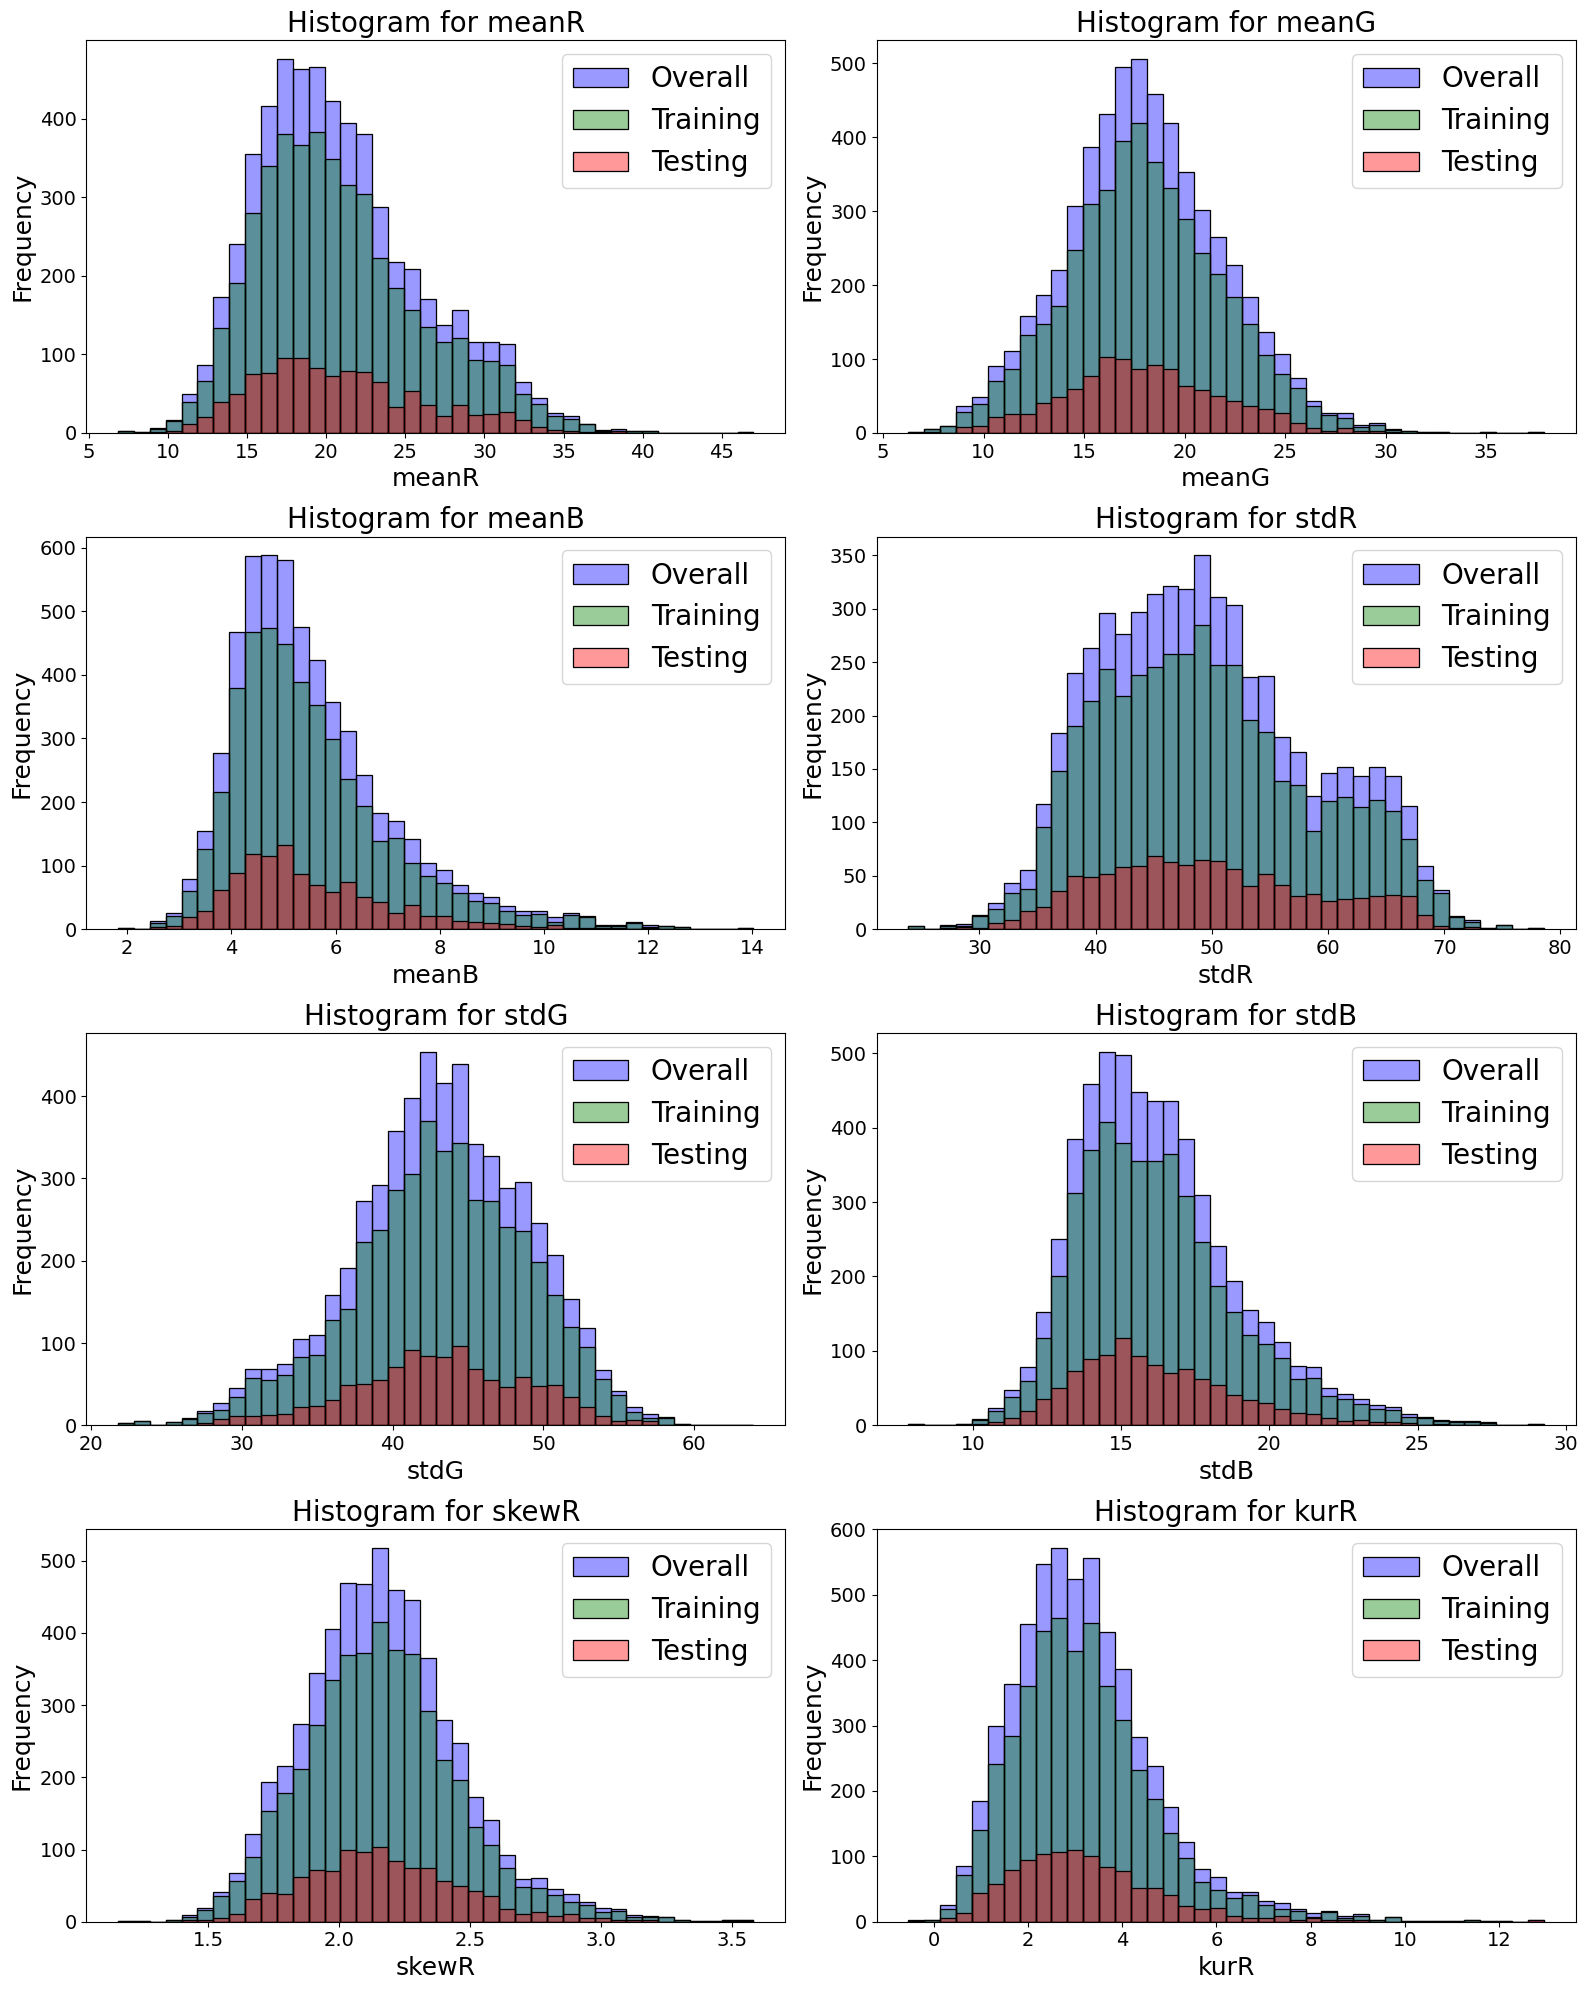

In [16]:
def plot_histograms(features, overall_data, train_data, test_data, bins=40, selected_features=None):
    # Use selected features if provided, otherwise default to all features
    features_to_plot = selected_features if selected_features else features
    
    num_features = len(features_to_plot)
    num_cols = 2
    num_rows = (num_features + num_cols - 1) // num_cols  # Calculate rows for grid

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, num_rows * 5))
    axes = axes.flatten()  # Flatten axes for easy indexing

    for i, feature in enumerate(features_to_plot):
        ax = axes[i]
        
        # Compute common bin edges for consistent alignment
        min_value = min(overall_data[feature].min(), train_data[feature].min(), test_data[feature].min())
        max_value = max(overall_data[feature].max(), train_data[feature].max(), test_data[feature].max())
        bin_edges = np.linspace(min_value, max_value, bins + 1)

        # Histogram with aligned bins
        sns.histplot(overall_data[feature], color="blue", alpha=0.4, bins=bin_edges, label="Overall", ax=ax)
        sns.histplot(train_data[feature], color="green", alpha=0.4, bins=bin_edges, label="Training", ax=ax)
        sns.histplot(test_data[feature], color="red", alpha=0.4, bins=bin_edges, label="Testing", ax=ax)

        ax.set_title(f"Histogram for {feature}", fontsize=20)  # Increase font size for title
        ax.set_xlabel(feature, fontsize=18)  # Increase font size for x-axis labels
        ax.set_ylabel('Frequency', fontsize=18)  # Increase font size for y-axis labels
        ax.legend(fontsize=20)  # Increase font size for legend
        
        # Adjusting tick label font size
        ax.tick_params(axis='both', labelsize=14)  # Adjust size of x and y tick numbers

    # Turn off unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

# Plot selected features 
plot_histograms(X.columns, X, X_train, X_test, selected_features=["meanR", "meanG", "meanB", "stdR", "stdG", "stdB", "skewR", "kurR"])


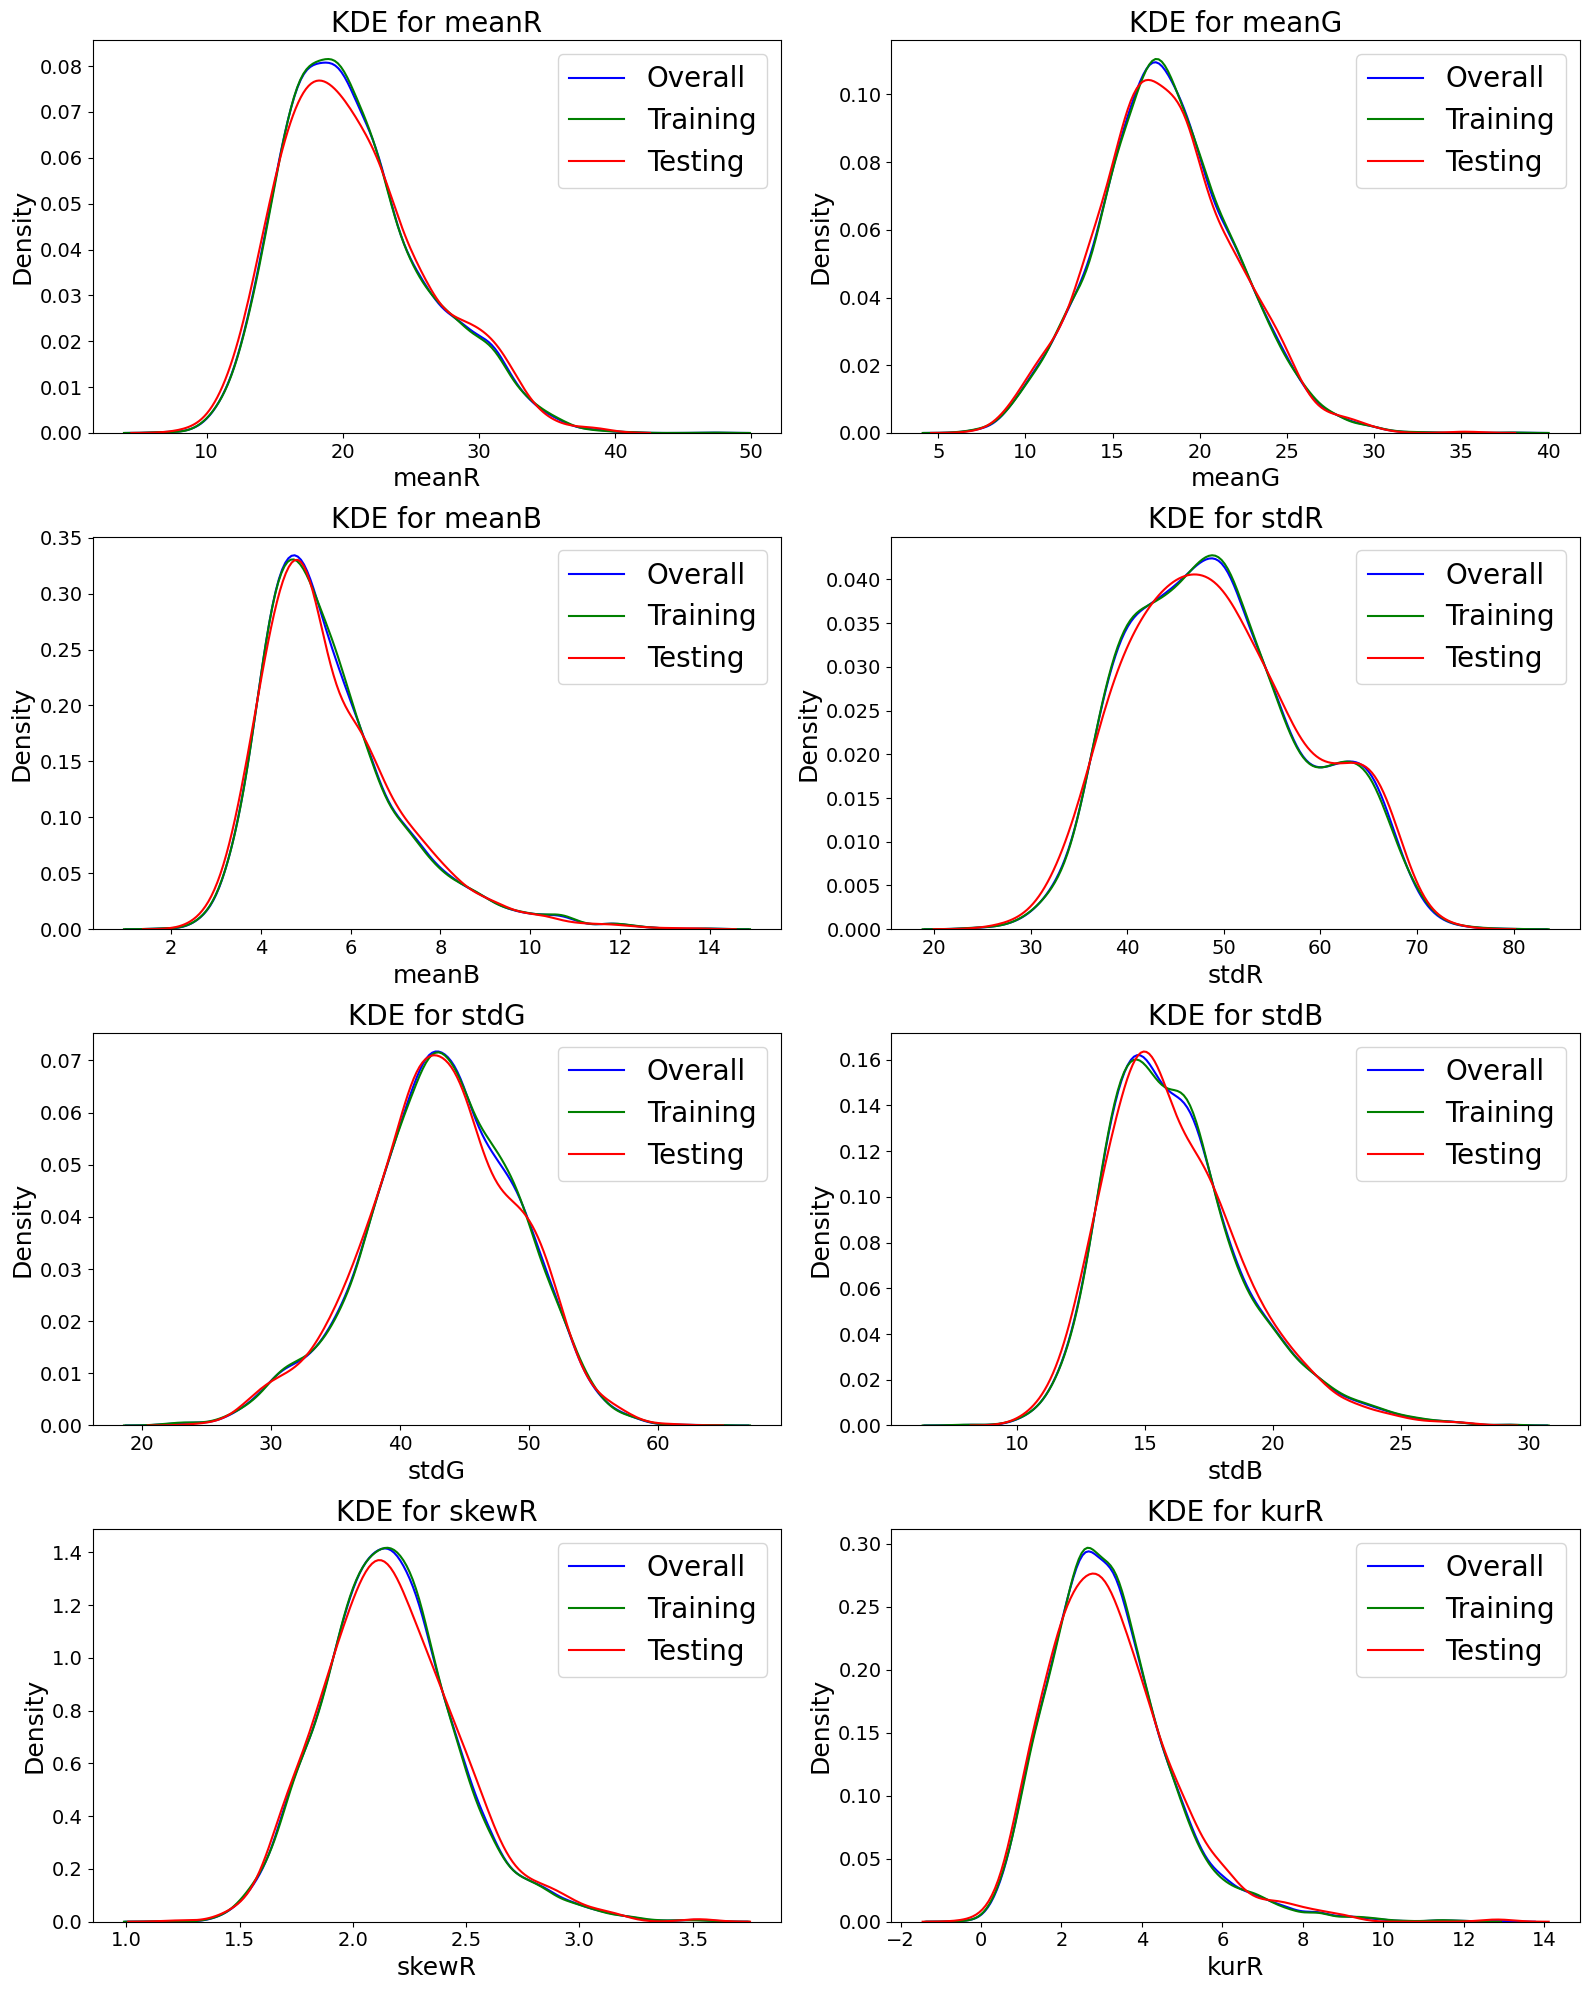

In [17]:
def plot_kde(features, overall_data, train_data, test_data, selected_features=None):
    # Use selected features if provided, otherwise default to all features
    features_to_plot = selected_features if selected_features else features
    
    num_features = len(features_to_plot)
    num_cols = 2
    num_rows = (num_features + num_cols - 1) // num_cols  # Calculate rows for grid

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, num_rows * 5))
    axes = axes.flatten()  # Flatten axes for easy indexing

    for i, feature in enumerate(features_to_plot):
        ax = axes[i]
        
        # KDE plots
        sns.kdeplot(overall_data[feature], color="blue", label="Overall", ax=ax)
        sns.kdeplot(train_data[feature], color="green", label="Training", ax=ax)
        sns.kdeplot(test_data[feature], color="red", label="Testing", ax=ax)
        
        ax.set_title(f"KDE for {feature}", fontsize=20)
        ax.set_xlabel(feature, fontsize=18)
        ax.set_ylabel('Density', fontsize=18)
        ax.legend(fontsize=20)
        ax.tick_params(axis='both', labelsize=14)  # Adjust tick label font size

    # Turn off unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

# Plot selected features
plot_kde(X.columns, X, X_train, X_test, selected_features=["meanR", "meanG", "meanB", "stdR", "stdG", "stdB", "skewR", "kurR"])

In [18]:
# Function to perform KS test and return results
def ks_test_overall_vs_training(features, overall_data, train_data, significance_level=0.05):
    results = []
    
    for feature in features:
        # Perform KS test
        statistic, p_value = ks_2samp(overall_data[feature], train_data[feature])
        
        # Check if distributions are similar (p-value > significance level)
        is_similar = p_value > significance_level
        
        # Append results
        results.append({
            "Feature": feature,
            "KS Statistic": statistic,
            "P-Value": p_value,
            "Similar": is_similar
        })
    
    # Convert to DataFrame
    return pd.DataFrame(results)

# Perform the KS test
ks_results = ks_test_overall_vs_training(X.columns, X, X_train)

ks_results.to_excel("results/ks_results.xlsx")

# Display the results
ks_results

,Feature,KS Statistic,P-Value,Similar
0,meanR,0.004364,1.000000,True
1,meanG,0.005446,0.999999,True
2,meanB,0.005744,0.999995,True
3,stdR,0.004462,1.000000,True
4,stdG,0.004782,1.000000,True
5,stdB,0.004282,1.000000,True
6,skewR,0.005048,1.000000,True
7,skewG,0.005525,0.999998,True
8,skewB,0.004947,1.000000,True
9,kurR,0.004798,1.000000,True


In [19]:
def analyze_normality_and_skewness(data):
    results = []
    
    for feature in data.columns:
        # Perform KS test against a normal distribution
        ks_stat, ks_p_value = kstest(data[feature], 'norm', args=(data[feature].mean(), data[feature].std()))
        is_normal_ks = ks_p_value >= 0.05
        
        # Compute skewness
        feature_skewness = skew(data[feature])
        is_normal_skew = -0.5 <= feature_skewness <= 0.5  # Threshold for approximate normality
        normal = feature_skewness and is_normal_skew
        
        # Append results
        results.append({
            "Feature": feature,
            "KS_p_value": ks_p_value,
            "Skewness": feature_skewness,
            "Normal": normal
        })
    
    # Create a DataFrame from results
    return pd.DataFrame(results)

In [20]:
def apply_boxcox_transformation(data):
    transformed_data = data.copy()
    for col in transformed_data.columns:
        if (transformed_data[col] > 0).all():
            transformed_data[col], _ = boxcox(transformed_data[col] + 1e-8)
    return transformed_data

In [21]:
def apply_log_transformation(data):
    transformed_data = data.copy()
    for col in transformed_data.columns:
        if (transformed_data[col] > 0).all():
            transformed_data[col] = np.log1p(transformed_data[col])
    return transformed_data

In [22]:
def apply_sqrt_transformation(data):
    transformed_data = data.copy()
    for col in transformed_data.columns:
        if (transformed_data[col] >= 0).all():
            transformed_data[col] = np.sqrt(transformed_data[col])
    return transformed_data

In [23]:
def apply_yeo_johnson_transformation(data):
    transformed_data = data.copy()
    numeric_cols = transformed_data.select_dtypes(include=['float64', 'int64']).columns
    
    # Winsorize outliers
    for col in numeric_cols:
        transformed_data[col] = mstats.winsorize(transformed_data[col], limits=[0.001, 0.001])

    # Apply log transformation
    transformed_data[numeric_cols] = transformed_data[numeric_cols].apply(np.log1p)

    # Apply Yeo-Johnson Power Transform
    pt = PowerTransformer(method='yeo-johnson')
    transformed_data[numeric_cols] = pt.fit_transform(transformed_data[numeric_cols])
    
    return transformed_data

In [24]:
# Function for Combined Transformations (Box-Cox -> Log -> Sqrt -> Yeo-Johnson)
def apply_combined_transformations(data):
    transformed_data = data.copy()
    data_boxcox = apply_boxcox_transformation(transformed_data)
    data_log = apply_log_transformation(data_boxcox)
    data_sqrt = apply_sqrt_transformation(data_log)
    data_yeo_johnson = apply_yeo_johnson_transformation(data_sqrt)
    return data_yeo_johnson

# Raw

In [25]:
normality_results = analyze_normality_and_skewness(X_train)
normality_results
normality_results.to_excel("results/raw_normality_results.xlsx")

# BoxCox

In [26]:
# Apply Box-Cox transformation
X_train_boxcox = apply_boxcox_transformation(X_train)

In [27]:
box_cox_normality_results = analyze_normality_and_skewness(X_train_boxcox)
box_cox_normality_results.to_excel("results/box_cox_normality_results.xlsx")
box_cox_normality_results

,Feature,KS_p_value,Skewness,Normal
0,meanR,3.261981e-02,0.000672,True
1,meanG,3.637699e-01,0.002702,True
2,meanB,9.181732e-02,-0.011394,True
3,stdR,2.012446e-05,-0.005173,True
4,stdG,4.770742e-01,-0.008547,True
5,stdB,2.506748e-01,-0.008714,True
6,skewR,1.239471e-01,-0.001554,True
7,skewG,6.569636e-02,-0.011095,True
8,skewB,1.894457e-02,0.007012,True
9,kurR,1.076184e-16,1.130780,False


# Log

In [28]:
# Apply Log transformation
X_train_log = apply_log_transformation(X_train)

In [29]:
log_normality_results = analyze_normality_and_skewness(X_train_log)
log_normality_results.to_excel("results/log_normality_results.xlsx")
log_normality_results

,Feature,KS_p_value,Skewness,Normal
0,meanR,1.900705e-02,0.062555,True
1,meanG,1.051328e-06,-0.458838,True
2,meanB,8.190297e-11,0.564604,False
3,stdR,4.529349e-05,-0.057467,True
4,stdG,4.667486e-10,-0.701666,False
5,stdB,9.241127e-05,0.364572,True
6,skewR,2.479392e-02,0.198721,True
7,skewG,1.499544e-08,0.543642,False
8,skewB,3.824370e-07,-0.300325,True
9,kurR,1.076184e-16,1.130780,False


# Sqrt

In [30]:
# Apply Square Root transformation
X_train_sqrt = apply_sqrt_transformation(X_train)

In [31]:
sqrt_normality_results = analyze_normality_and_skewness(X_train_sqrt)
sqrt_normality_results.to_excel("results/sqrt_normality_results.xlsx")
sqrt_normality_results

,Feature,KS_p_value,Skewness,Normal
0,meanR,1.589465e-07,0.349854,True
1,meanG,3.003721e-02,-0.140608,True
2,meanB,8.306258e-20,0.860419,False
3,stdR,2.702832e-06,0.130040,True
4,stdG,2.316581e-05,-0.476131,True
5,stdB,1.442595e-08,0.599329,False
6,skewR,6.579923e-03,0.288843,True
7,skewG,6.882104e-11,0.650362,False
8,skewB,2.364842e-04,-0.143564,True
9,kurR,1.076184e-16,1.130780,False


# Yeo Johnson

In [32]:
X_train_yeo_johnson = apply_yeo_johnson_transformation(X_train)

In [33]:
yeo_johnson_normality_result = analyze_normality_and_skewness(X_train_yeo_johnson)
yeo_johnson_normality_result.to_excel("results/yeo_johnson_normality_result.xlsx")
yeo_johnson_normality_result

,Feature,KS_p_value,Skewness,Normal
0,meanR,0.031208,-0.002576,True
1,meanG,0.445346,-0.003895,True
2,meanB,0.203365,-0.000409,True
3,stdR,0.000021,-0.010598,True
4,stdG,0.509162,-0.016017,True
5,stdB,0.416752,-0.001339,True
6,skewR,0.168789,-0.001295,True
7,skewG,0.109178,-0.006093,True
8,skewB,0.048290,-0.003059,True
9,kurR,0.044820,0.012605,True


# Combined

In [34]:
# Apply Combined Transformations
X_train_combination = apply_combined_transformations(X_train)

In [35]:
combination_normality_results = analyze_normality_and_skewness(X_train_combination)
combination_normality_results.to_excel("results/combination_normality_results.xlsx")
combination_normality_results

,Feature,KS_p_value,Skewness,Normal
0,meanR,0.032830,-0.007972,True
1,meanG,0.470381,-0.005952,True
2,meanB,0.186424,0.003593,True
3,stdR,0.000022,-0.013901,True
4,stdG,0.490523,-0.018124,True
5,stdB,0.415664,0.000325,True
6,skewR,0.175526,0.009557,True
7,skewG,0.089898,0.008059,True
8,skewB,0.038902,-0.015353,True
9,kurR,0.044820,0.012605,True


In [36]:
# Manually input method names
method_names = [
    "Normal", 
    "Box-Cox", 
    "Log", 
    "Sqrt", 
    "Yeo-Johnson", 
    "Combination"
]

# Define a function to combine results into the desired format
def combine_normality_results(*results, method_names):
    combined = []
    
    for result, method_name in zip(results, method_names):
        # Count the number of passed and failed features
        normalized_count = result["Normal"].sum()  # Count of normal features (True)
        failed_count = len(result) - normalized_count  # Count of failed features (False)
        
        combined.append({
            "Method": method_name,
            "Normalized Features Count": normalized_count,
            "Failed Count": failed_count
        })
    
    return pd.DataFrame(combined)

# Combine all the results
combined_results = combine_normality_results(
    normality_results,
    box_cox_normality_results,
    log_normality_results,
    sqrt_normality_results,
    yeo_johnson_normality_result,
    combination_normality_results,
    method_names=method_names
)

combined_results.to_excel("results/normality_results.xlsx")

# Display the final combined result
combined_results

,Method,Normalized Features Count,Failed Count
0,Normal,7,8
1,Box-Cox,13,2
2,Log,10,5
3,Sqrt,10,5
4,Yeo-Johnson,15,0
5,Combination,15,0


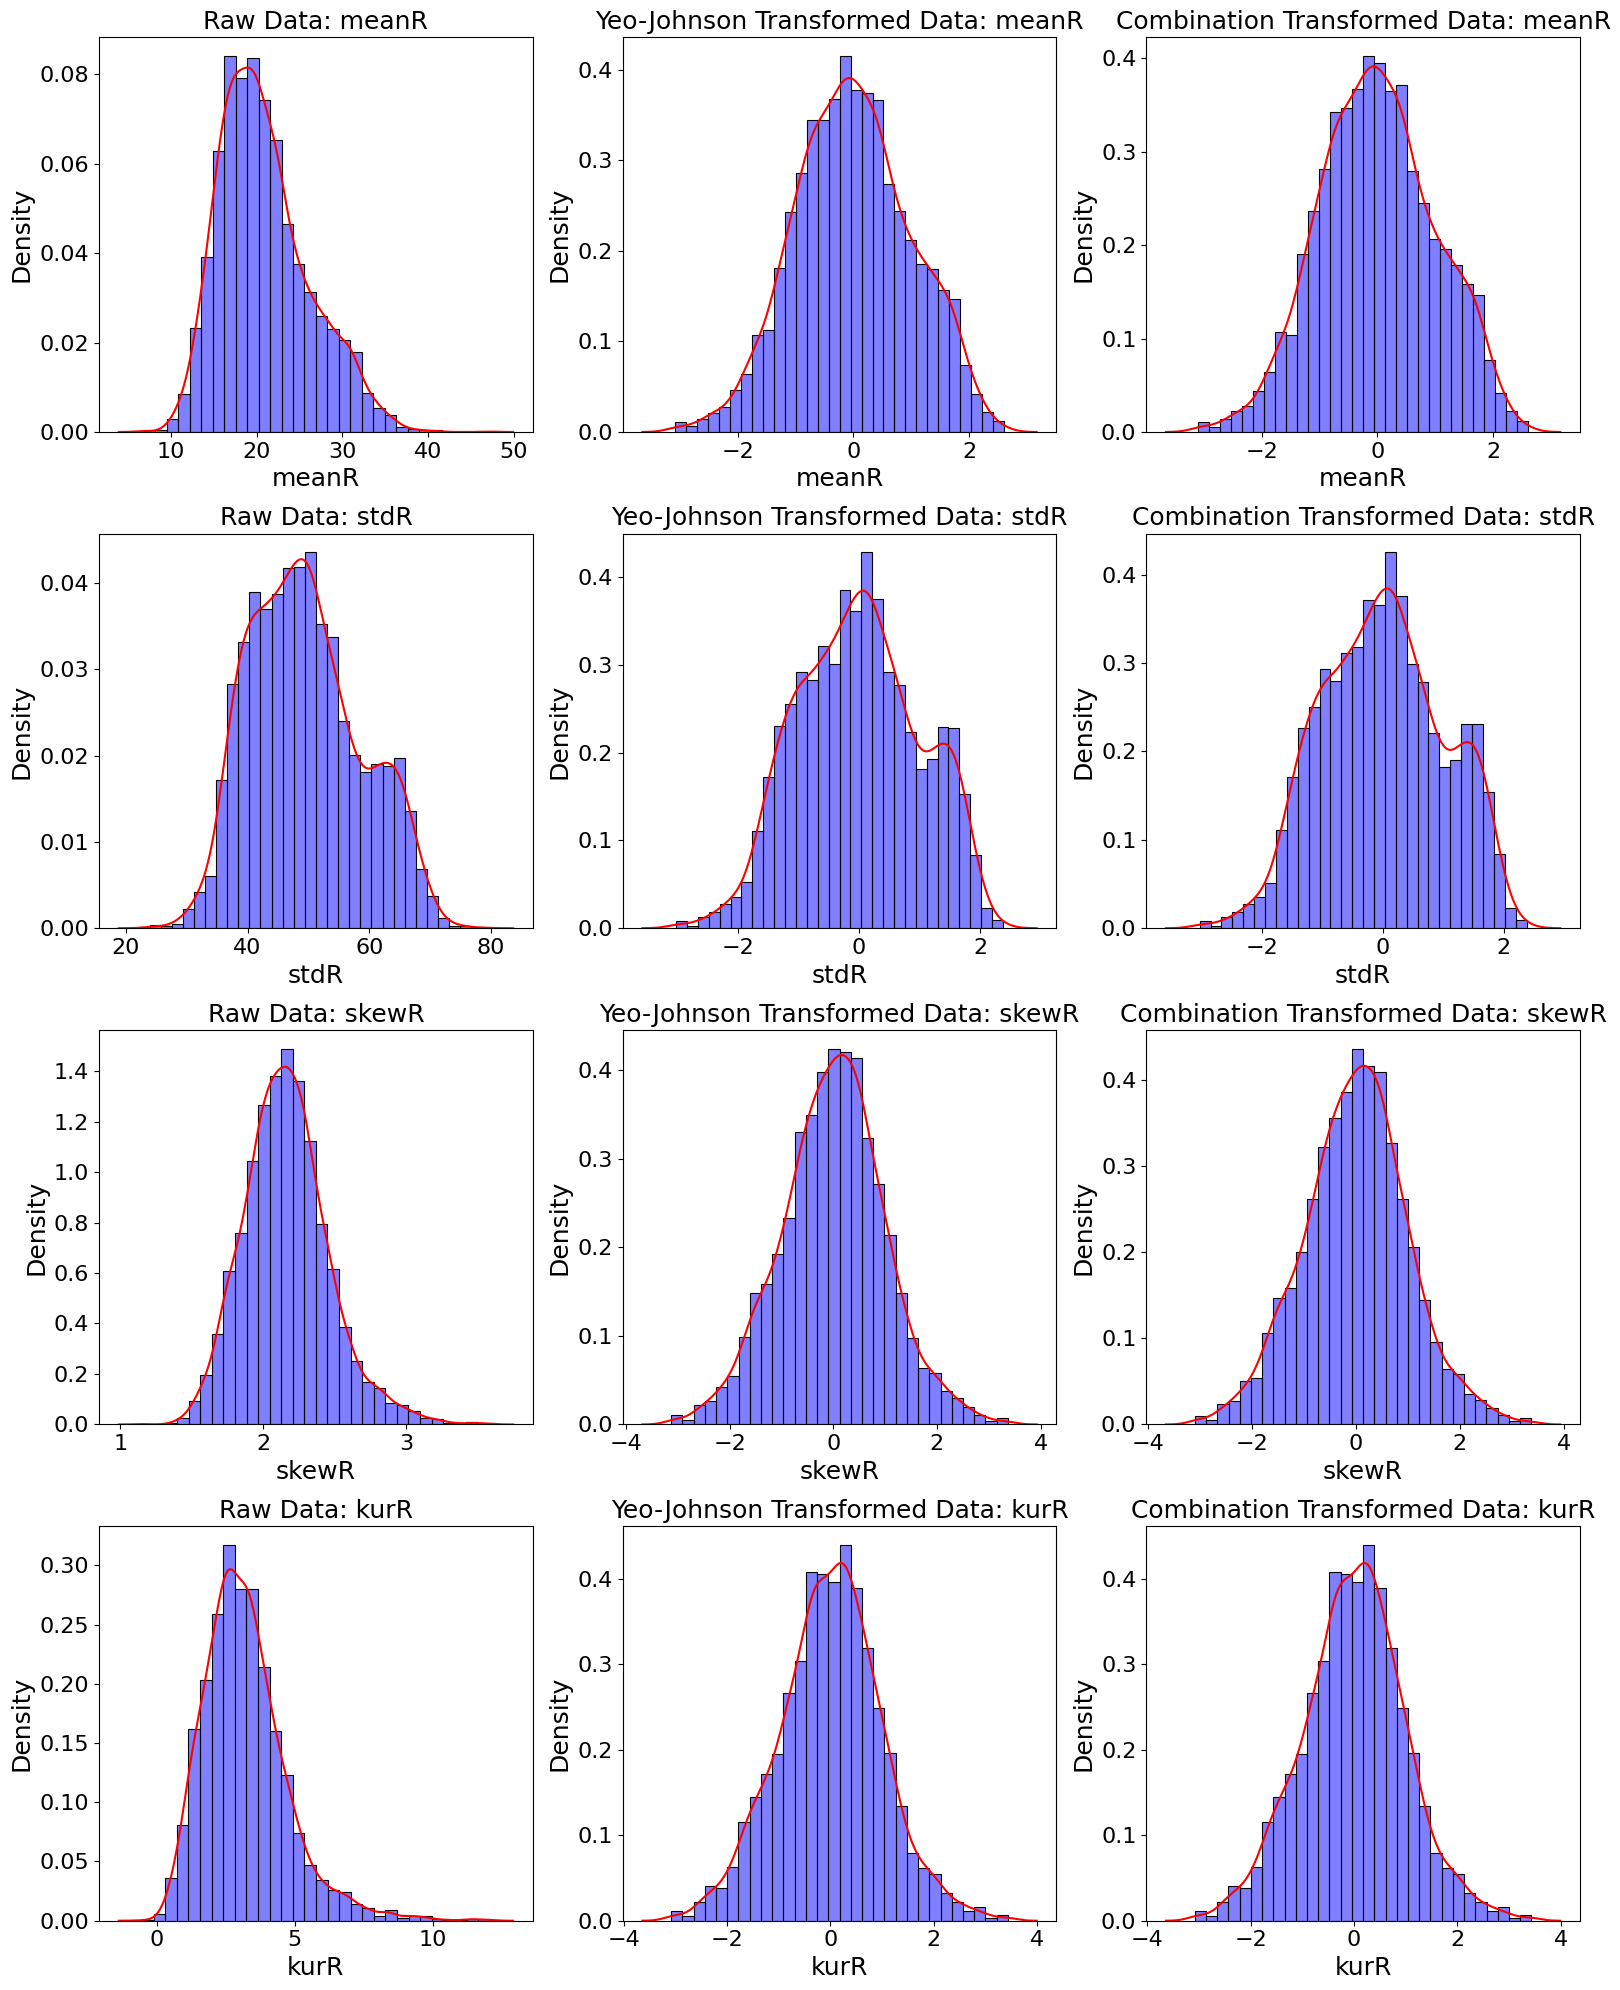

In [37]:
# Function to plot histogram with KDE for multiple datasets
def plot_histogram_with_kde_multiple_datasets(datasets, titles, selected_features=None):
    # Determine features to plot
    features = selected_features if selected_features else datasets[0].columns
    num_features = len(features)
    num_datasets = len(datasets)  # Number of datasets to plot side by side
    num_rows = num_features  # One row for each feature

    fig, axes = plt.subplots(num_rows, num_datasets, figsize=(16, num_rows * 5))
    axes = axes.flatten()

    for i, (data, title) in enumerate(zip(datasets, titles)):
        for j, col in enumerate(features):
            ax = axes[j * num_datasets + i]  # Correct indexing: one column per dataset

            # Plot normalized histogram
            sns.histplot(data[col], bins=30, color="blue", alpha=0.5, kde=False, stat="density", ax=ax, label="Histogram")
            
            # Plot KDE
            sns.kdeplot(data[col], color="red", ax=ax, label="KDE")
            
            ax.set_title(f"{title}: {col}", fontsize=18)

    # Turn off unused subplots
    for j in range(num_features * num_datasets, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

# List of datasets and corresponding titles
datasets = [X_train, X_train_yeo_johnson, X_train_combination]
titles = ["Raw Data", "Yeo-Johnson Transformed Data", "Combination Transformed Data"]

# Plot selected features
plot_histogram_with_kde_multiple_datasets(datasets, titles, selected_features=["meanR", "stdR", "skewR", "kurR"])
